In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

import transformers

# import torch.distributed as dist
# from torch.utils.data.distributed import DistributedSampler
# from torch.nn.parallel import DistributedDataParallel as DDP
# import torch.multiprocessing as mp
# from ddputils import is_main_process, save_on_master, setup_for_distributed


# from PIL import Image
from torch.utils.data import Dataset
import random
from copy import deepcopy
import json
import itertools
import gc

In [3]:
import math
from functools import partial
import numpy as np

import torch
import torch.nn as nn

from tensors import (
    trunc_normal_,
    repeat_interleave_batch,
    apply_masks
)

import logging

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()

In [4]:
# pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1],
#                                     int(self.patch_embed.num_patches**.5),
#                                     cls_token=False)
    
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)

    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x




In [5]:
class PatchEmbed(nn.Module):
     #@@@
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, num_frames=1, 
                 tubelet_size=1, in_chans=3, embed_dim=768):
        super().__init__()
#         num_patches = (img_size // patch_size) * (img_size // patch_size)
        num_patches = (
            (img_size // patch_size) * (img_size // patch_size) * (num_frames // tubelet_size)
        )
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.tubelet_size = tubelet_size

#         self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.proj = nn.Conv3d(
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=(self.tubelet_size, patch_size, patch_size),
            stride=(self.tubelet_size, patch_size, patch_size)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4)
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """
    3x3 Convolution stems for ViT following ViTC models
    """

    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3,
                               stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)




In [6]:
class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=3,
        num_frames=1,
        tubelet_size=1,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=12,
        predictor_depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        # --
         #@@@
        self.patch_embed = PatchEmbed(
            img_size=img_size[0],
            patch_size=patch_size,
            tubelet_size=tubelet_size,
            num_frames=num_frames,
            in_chans=in_chans,
            embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        print('self.pos_embed shape:',self.pos_embed.shape)
        
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1],
                                            int(self.patch_embed.num_patches**.5),
                                            cls_token=False)
        print('pos_embed shape:',pos_embed.shape)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # ------
        self.init_std = init_std
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)

        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N:
            return pos_embed
        class_emb = pos_embed[:, 0]
        pos_embed = pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(
            pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=math.sqrt(npatch / N),
            mode='bicubic',
        )
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

In [7]:

def vit_predictor(**kwargs):
    model = VisionTransformerPredictor(
        mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    return model


def vit_tiny(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_small(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_giant(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1408, depth=40, num_heads=16, mlp_ratio=48/11,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


VIT_EMBED_DIMS = {
    'vit_tiny': 192,
    'vit_small': 384,
    'vit_base': 768,
    'vit_large': 1024,
    'vit_huge': 1280,
    'vit_giant': 1408,
}


In [20]:

 #@@@
def init_model(
    device,
    patch_size=16,
    tubelet_size=1,
    num_frames=1,
    model_name='vit_base',
    crop_size=224,
    pred_depth=6,
    pred_emb_dim=384
):
#     encoder = vit.__dict__[model_name](
    encoder = vit_base(
        img_size=[crop_size],
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=tubelet_size) #@@@
#     predictor = vit.__dict__['vit_predictor'](
    predictor = vit_predictor(
        sequence_shape=encoder.sequence_shape,
        embed_dim=encoder.embed_dim,
        predictor_embed_dim=pred_emb_dim,
        depth=pred_depth,
        num_heads=encoder.num_heads)

    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.LayerNorm):
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1.0)

    for m in encoder.modules():
        init_weights(m)

    for m in predictor.modules():
        init_weights(m)

    encoder.to(device)
    predictor.to(device)
    logger.info(encoder)
    return encoder, predictor

In [21]:
device= 'cuda:0'#'cpu'
patch_size=16
crop_size=224
pred_depth=6
pred_emb_dim=384
model_name='vit_base'#'vit_small'
tubelet_size=2 #@@@
num_frames=6 #@@@

encoder, predictor = init_model(
    device=device,
    patch_size=patch_size,
    crop_size=crop_size,
    pred_depth=pred_depth,
    pred_emb_dim=pred_emb_dim,
    model_name=model_name,
    tubelet_size=tubelet_size,
    num_frames=num_frames)

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear

In [11]:
3*(224//16)**2

588

In [24]:
xtt = torch.rand(8,6,3,224,224).to(device)

In [25]:
z = encoder(xtt)
# predictor(z)

In [12]:
def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)

class PositionalEncoding3D(nn.Module):
    """
    From https://github.com/tatp22/multidim-positional-encoding/tree/master
    
    """
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding3D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 6) * 2)
        if channels % 2:
            channels += 1
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.register_buffer("cached_penc", None)

    def forward(self, tensor):
        """
        :param tensor: A 5d tensor of size (batch_size, x, y, z, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, z, ch)
        """
        if len(tensor.shape) != 5:
            raise RuntimeError("The input tensor has to be 5d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, y, z, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        pos_z = torch.arange(z, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        sin_inp_z = torch.einsum("i,j->ij", pos_z, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1).unsqueeze(1)
        emb_y = get_emb(sin_inp_y).unsqueeze(1)
        emb_z = get_emb(sin_inp_z)
        emb = torch.zeros((x, y, z, self.channels * 3), device=tensor.device).type(
            tensor.type()
        )
        emb[:, :, :, : self.channels] = emb_x
        emb[:, :, :, self.channels : 2 * self.channels] = emb_y
        emb[:, :, :, 2 * self.channels :] = emb_z

        self.cached_penc = emb[None, :, :, :, :orig_ch].repeat(batch_size, 1, 1, 1, 1)
        return self.cached_penc


In [13]:
p_enc_3d_model = PositionalEncoding3D(768)

x = torch.rand(8, 6//2, 224//16, 224//16, 768)
ytt = p_enc_3d_model(x) # penc_no_sum.shape == (1, 6, 10)
ytt.shape

torch.Size([8, 3, 14, 14, 768])

In [48]:
torch.all(ytt[0,...]==ytt[1,...])

tensor(True)

In [50]:
import matplotlib.pyplot as plt

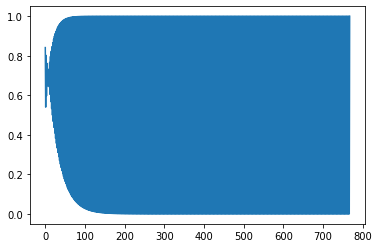

In [55]:
plt.plot(ytt[0,1,0,0,:])

In [56]:
from torch.nn.functional import pairwise_distance as pdist

In [64]:
x1 = ytt[0, 0, 1,0,:]
x2 = ytt[0, 0, 2,0,:]
pdist(x1,x2)

tensor(2.6712)

In [60]:
x1 = ytt[0, 0, 0,0,:]
x2 = ytt[0, 0, 2,0,:]
pdist(x1,x2)

tensor(4.9991)

In [66]:
torch.all(x1==x2)

tensor(False)

In [18]:
class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=3,
        num_frames=1,
        tubelet_size=1,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=12,
        predictor_depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        # --
         #@@@
        self.patch_embed = PatchEmbed(
            img_size=img_size[0],
            patch_size=patch_size,
            tubelet_size=tubelet_size,
            num_frames=num_frames,
            in_chans=in_chans,
            embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        #@@@
        sequence_shape = (num_frames//tubelet_size, img_size[0]//patch_size,
                       img_size[0]//patch_size)
        self.sequence_shape = sequence_shape
        p_enc_3d_model = PositionalEncoding3D(embed_dim)
        tmp_input = torch.rand(1, *sequence_shape, embed_dim)
        pos_embed = p_enc_3d_model(tmp_input).reshape(1,-1,embed_dim)
#         pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1],
#                                             int(self.patch_embed.num_patches**.5),
#                                             cls_token=False)
#         self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        self.pos_embed.data.copy_(pos_embed.float())
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # ------
        self.init_std = init_std
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)

        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N:
            return pos_embed
        class_emb = pos_embed[:, 0]
        pos_embed = pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(
            pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=math.sqrt(npatch / N),
            mode='bicubic',
        )
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)


In [19]:
class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        sequence_shape,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=6,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):
        super().__init__()
        num_patches = np.prod(sequence_shape)
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim),
                                                requires_grad=False)
        
        p_enc_3d_model = PositionalEncoding3D(predictor_embed_dim)
        tmp_input = torch.rand(1, *sequence_shape, predictor_embed_dim)
        predictor_pos_embed = p_enc_3d_model(tmp_input).reshape(
            1,-1,predictor_embed_dim)
        self.predictor_pos_embed.data.copy_(predictor_pos_embed.float())

#         predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1],
#                                                       int(num_patches**.5),
#                                                       cls_token=False)
#         self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0))
        # --
        self.predictor_blocks = nn.ModuleList([
            Block(
                dim=predictor_embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.predictor_norm = norm_layer(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        self.init_std = init_std
        trunc_normal_(self.mask_token, std=self.init_std)
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.predictor_blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'

        if not isinstance(masks_x, list):
            masks_x = [masks_x]

        if not isinstance(masks, list):
            masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x)

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x)

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1)
        x += apply_masks(x_pos_embed, masks_x)

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)

        return x




